In [71]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Each row contains data from each card from each deck used in each official tournaments from 2011-2023.**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



import warnings
warnings.filterwarnings('ignore')

I Have Imported some basic math and learning functionality to help tighten our analysis of a large varied data set of competitive gaming data 

In [73]:
df = pd.read_csv('tournaments.csv')



<span style="font-family:Gill Sans; font-size:4em;">This reads a tournament registration for the card game pokemon: A physical pokemon card has certain aspects to it that allows it to compete in a standardized ruleset </span>

In [74]:
def prepare_tcg_data_for_pca(df):
    """
    Prepare Pokémon TCG data for PCA analysis
    """
    # Select numerical features that might be relevant for PCA
    # Adjust these based on your actual dataset columns
    numerical_features = [
        'price',                     # Card price
        'copies_per_deck',          # Average copies in deck
        'tournament_appearances',   # How often card appears in tournaments
        'win_rate',                 # If available
        'deck_count',               # Number of decks card appears in
        'player_count',             # Number of players using card
        # Add other numerical features from your dataset
    ]
    
    # Create dummy variables for categorical features
    categorical_features = ['card_type', 'energy_type', 'region']
    
    # One-hot encode categorical variables
    for feature in categorical_features:
        if feature in df.columns:
            dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            numerical_features.extend(dummies.columns.tolist())
    
    # Also include archetype usage if available
    if 'archetype_usage_pct' in df.columns:
        numerical_features.append('archetype_usage_pct')
    
    # Filter to only include existing columns
    available_features = [f for f in numerical_features if f in df.columns]
    
    # Handle missing values
    df_pca = df[available_features].fillna(0)
    
    return df_pca, available_features

In [75]:
def perform_pca_analysis(df_features, n_components=None):
    """
    Perform PCA on the prepared data
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_features)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)
    
    # Create DataFrame with principal components
    pc_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    df_pca_results = pd.DataFrame(principal_components, columns=pc_columns)
    
    # Calculate variance explained
    variance_explained = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_explained)
    
    return pca, df_pca_results, variance_explained, cumulative_variance, scaled_data

In [76]:
def create_scree_plot(variance_explained, save_path=None):
    """
    Create scree plot showing variance explained by each component
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar plot
    components = range(1, len(variance_explained) + 1)
    bars = ax.bar(components, variance_explained * 100, 
                  color='steelblue', alpha=0.7)
    
    # Add line plot for cumulative variance
    ax2 = ax.twinx()
    cumulative_variance = np.cumsum(variance_explained) * 100
    ax2.plot(components, cumulative_variance, 
             color='crimson', marker='o', linewidth=2, markersize=8)
    
    # Customize primary y-axis
    ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
    ax.set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
    ax.set_xticks(components)
    ax.set_xticklabels([f'PC{i}' for i in components], rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Customize secondary y-axis
    ax2.set_ylabel('Cumulative Variance (%)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    # Add value labels on bars
    for bar, variance in zip(bars, variance_explained * 100):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{variance:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='steelblue', alpha=0.7, label='Individual Variance'),
        Line2D([0], [0], color='crimson', lw=2, marker='o', 
               label='Cumulative Variance')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.title('PCA Scree Plot: Variance Explained by Principal Components', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print elbow point analysis
    print("Variance Explained by First Few Components:")
    for i, var in enumerate(variance_explained[:10], 1):
        print(f"PC{i}: {var*100:.2f}%")
    
    # Find elbow point (simplified method)
    diffs = np.diff(variance_explained)
    elbow_point = np.argmin(diffs) + 2  # +2 because diff reduces length by 1
    print(f"\nSuggested number of components (elbow point): {elbow_point}")

In [97]:
def run_full_pca_analysis(df, metadata_cols=None):
    """
    Run complete PCA analysis on Pokémon TCG data
    """
    print("=" * 70)
    print("PCA ANALYSIS FOR POKÉMON TCG TOURNAMENT DATA")
    print("=" * 70)
    
    # Step 1: Prepare data
    print("\n1. Preparing data for PCA...")
    df_pca_features, feature_names = prepare_tcg_data_for_pca(df)
    print(f"   Using {len(feature_names)} features for PCA")
    print(f"   Features: {', '.join(feature_names[:10])}...")
    
    # Step 2: Perform PCA
    print("\n2. Performing PCA...")
    pca, df_pca_results, variance_explained, cumulative_variance, scaled_data = \
        perform_pca_analysis(df_pca_features)
    
    # Step 3: Create visualizations
    print("\n3. Creating visualizations...")
    
    # Visualization 1: Scree Plot
    print("   • Creating Scree Plot...")
    create_scree_plot(variance_explained, 
                     save_path='pca_scree_plot.png')

In [106]:
prepare_tcg_data_for_pca(df)

(Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
 
 [114291 rows x 0 columns],
 [])

In [77]:
# Check first 5 lines

df.head()

,id_card,name_card,amount_card,price_card,energy_type_card,type_card,combo_type_id,combo_type_name,id_player,name_player,...,region_tournament,country_tournament,year_tournament,month_tournament,day_tournament,valid_rotation_at_tournament,rotation_name,year_begin,month_begin,day_begin
0,SSP272,Archeops,4,0.70,Colorless,Pokémon,247.0,Lugia Archeops,5101,Alexander Flatos,...,NaN,United States,2023,10,14,BST-OBF,standard_2023,2023,4,14
1,SIT138,Lugia V,3,6.20,Colorless,Pokémon,247.0,Lugia Archeops,5101,Alexander Flatos,...,NaN,United States,2023,10,14,BST-OBF,standard_2023,2023,4,14
2,SIT139,Lugia VSTAR,3,8.71,Colorless,Pokémon,247.0,Lugia Archeops,5101,Alexander Flatos,...,NaN,United States,2023,10,14,BST-OBF,standard_2023,2023,4,14
3,LOR143,Snorlax,3,0.93,Colorless,Pokémon,247.0,Lugia Archeops,5101,Alexander Flatos,...,NaN,United States,2023,10,14,BST-OBF,standard_2023,2023,4,14
4,SSP250,Lumineon V,2,1.90,Water,Pokémon,247.0,Lugia Archeops,5101,Alexander Flatos,...,NaN,United States,2023,10,14,BST-OBF,standard_2023,2023,4,14


In [78]:
# Check last 5 lines

df.tail()

,id_card,name_card,amount_card,price_card,energy_type_card,type_card,combo_type_id,combo_type_name,id_player,name_player,...,region_tournament,country_tournament,year_tournament,month_tournament,day_tournament,valid_rotation_at_tournament,rotation_name,year_begin,month_begin,day_begin
114286,GRI130a,Rescue Stretcher,2,0.72,NaN,Trainer,47.0,Zoroark Greninja,1900,Jin Woo Lee,...,AS-OC,Korea,2018,12,22,NaN,standard_2019,2018,8,28
114287,GRI119,Aqua Patch,2,0.27,NaN,Trainer,47.0,Zoroark Greninja,1900,Jin Woo Lee,...,AS-OC,Korea,2018,12,22,NaN,standard_2019,2018,8,28
114288,FLF092,Pal Pad,1,0.68,NaN,Trainer,47.0,Zoroark Greninja,1900,Jin Woo Lee,...,AS-OC,Korea,2018,12,22,NaN,standard_2019,2018,8,28
114289,GRI121,Choice Band,2,0.20,NaN,Trainer,47.0,Zoroark Greninja,1900,Jin Woo Lee,...,AS-OC,Korea,2018,12,22,NaN,standard_2019,2018,8,28
114290,GRI120,Brooklet Hill,2,0.32,NaN,Trainer,47.0,Zoroark Greninja,1900,Jin Woo Lee,...,AS-OC,Korea,2018,12,22,NaN,standard_2019,2018,8,28


In [79]:
# Check Dataframe information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114291 entries, 0 to 114290
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id_card                       114291 non-null  object 
 1   name_card                     114291 non-null  object 
 2   amount_card                   114291 non-null  int64  
 3   price_card                    110601 non-null  float64
 4   energy_type_card              42447 non-null   object 
 5   type_card                     114291 non-null  object 
 6   combo_type_id                 114244 non-null  float64
 7   combo_type_name               114244 non-null  object 
 8   id_player                     114291 non-null  int64  
 9   name_player                   114291 non-null  object 
 10  country_player                114291 non-null  object 
 11  all_time_score                114291 non-null  int64  
 12  ranking_player_tournament     114291 non-nul

In [80]:
# Numerical features

df.describe(exclude=['O'])

,amount_card,price_card,combo_type_id,id_player,all_time_score,ranking_player_tournament,id_tournament,year_tournament,month_tournament,day_tournament,year_begin,month_begin,day_begin
count,114291.000000,110601.000000,114244.000000,114291.000000,114291.000000,114291.000000,114291.000000,114291.000000,114291.000000,114291.000000,114291.000000,114291.000000,114291.000000
mean,2.150869,1.996521,193.066297,2432.756341,100.721177,47.290469,300.991942,2021.575461,6.172507,13.954047,2020.830573,6.883289,12.963444
std,1.172458,5.537550,75.891478,1689.635106,158.626738,42.015853,89.110764,2.330584,3.194120,8.229426,2.449667,2.332956,6.361826
min,1.000000,0.020000,1.000000,1.000000,1.000000,1.000000,4.000000,2011.000000,1.000000,1.000000,2010.000000,4.000000,1.000000
25%,1.000000,0.170000,167.000000,712.000000,12.000000,13.000000,289.000000,2020.000000,4.000000,7.000000,2020.000000,4.000000,10.000000
50%,2.000000,0.640000,227.000000,2435.000000,34.000000,35.000000,329.000000,2023.000000,6.000000,14.000000,2021.000000,8.000000,14.000000
75%,3.000000,2.160000,247.000000,4055.000000,108.000000,70.000000,359.000000,2023.000000,9.000000,21.000000,2023.000000,9.000000,14.000000
max,4.000000,246.620000,265.000000,5162.000000,943.000000,193.000000,410.000000,2023.000000,12.000000,30.000000,2023.000000,9.000000,28.000000


In [81]:
# Categorical features

df.describe(include=['O'])

,id_card,name_card,energy_type_card,type_card,combo_type_name,name_player,country_player,category_tournament,name_tournament,region_tournament,country_tournament,valid_rotation_at_tournament,rotation_name
count,114291,114291,42447,114291,114244,114291,114291,114291,114291,58412,114291,98686,114291
unique,1707,1323,22,2,376,2653,47,5,119,4,26,21,13
top,DEX102,Ultra Ball,Psychic,Trainer,Lugia Archeops,Tord Reklev,United States,regional,NAIC 2023 Columbus,EU,United States,SSH-SIT,standard_2023
freq,3698,3698,8673,71844,17646,607,50127,52978,4391,23165,53947,30998,44610


In [82]:
# Check row and column numbers

rows = df.shape[0] 
cols = df.shape[1] 
print("Rows   : " + str(rows)) 
print("Columns: " + str(cols))

Rows   : 114291
Columns: 26


In [83]:
# Check duplicate data

print("Number of duplicates: " + str(df.duplicated().sum()))

Number of duplicates: 84


In [84]:
# Number of unique values per column.

df.nunique()

id_card                         1707
name_card                       1323
amount_card                        4
price_card                       558
energy_type_card                  22
type_card                          2
combo_type_id                    189
combo_type_name                  376
id_player                       2656
name_player                     2653
country_player                    47
all_time_score                   228
ranking_player_tournament        193
id_tournament                    133
category_tournament                5
name_tournament                  119
region_tournament                  4
country_tournament                26
year_tournament                   13
month_tournament                  12
day_tournament                    29
valid_rotation_at_tournament      21
rotation_name                     13
year_begin                        13
month_begin                        3
day_begin                          6
dtype: int64

In [85]:
# Check the unique values for 'year_tournament' column.

df['year_tournament'].unique()

array([2023, 2022, 2018, 2016, 2015, 2014, 2013, 2020, 2019, 2017, 2012,
       2011, 2021])

In [86]:
# Check the unique values and frequency for 'year_tournament' column

df['year_tournament'].value_counts()

year_tournament
2023    70158
2022    14660
2019    11446
2018     6718
2020     2766
2017     2641
2016     1941
2015     1606
2014      960
2021      607
2013      498
2011      175
2012      115
Name: count, dtype: int64

In [87]:
# minimum (min) and maximum (max) value of 'year_tournament' column.

print(df['year_tournament'].min())
print(df['year_tournament'].max())

2011
2023


In [88]:
# Print data from a specific line (row = 100)

print("Value of row 100")
display(df.iloc[100])

Value of row 100


id_card                                         NXD089
name_card                                   Level Ball
amount_card                                          4
price_card                                        0.99
energy_type_card                                   NaN
type_card                                      Trainer
combo_type_id                                    255.0
combo_type_name                              Gardevoir
id_player                                          765
name_player                                Ryan Harris
country_player                           United States
all_time_score                                      86
ranking_player_tournament                            5
id_tournament                                      387
category_tournament                           regional
name_tournament                 Regional Sacramento CA
region_tournament                                  NaN
country_tournament                       United States
year_tourn

In [89]:
# Locate specific data in the column "price_card = 2.73"

print(df[df['price_card'] == 2.73])


       id_card          name_card  amount_card  price_card energy_type_card  \
104299  SSP123  Galarian Articuno            1        2.73          Psychic   

       type_card  combo_type_id combo_type_name  id_player   name_player  ...  \
104299   Pokémon          255.0       Gardevoir       4107  Kohei Otsuki  ...   

       region_tournament  country_tournament  year_tournament  \
104299                JP               Japan             2023   

        month_tournament day_tournament valid_rotation_at_tournament  \
104299                 2             25                          NaN   

        rotation_name year_begin  month_begin  day_begin  
104299  standard_2022       2021            9         10  

[1 rows x 26 columns]


In [90]:
## We select the categorical and numeric variables to plot.

# Categorical variables:
cat_cols = df.select_dtypes(include = ['object', 'category']).columns.to_list()

# Numerical variables:
num_cols = df.select_dtypes(include = ['float', 'int']).columns.to_list()

In [91]:
df.to_csv('cleaned_pokemon_tournament_data.csv', index=False)
print(f"\nCleaned data saved to 'cleaned_pokemon_tournament_data.csv'")


Cleaned data saved to 'cleaned_pokemon_tournament_data.csv'


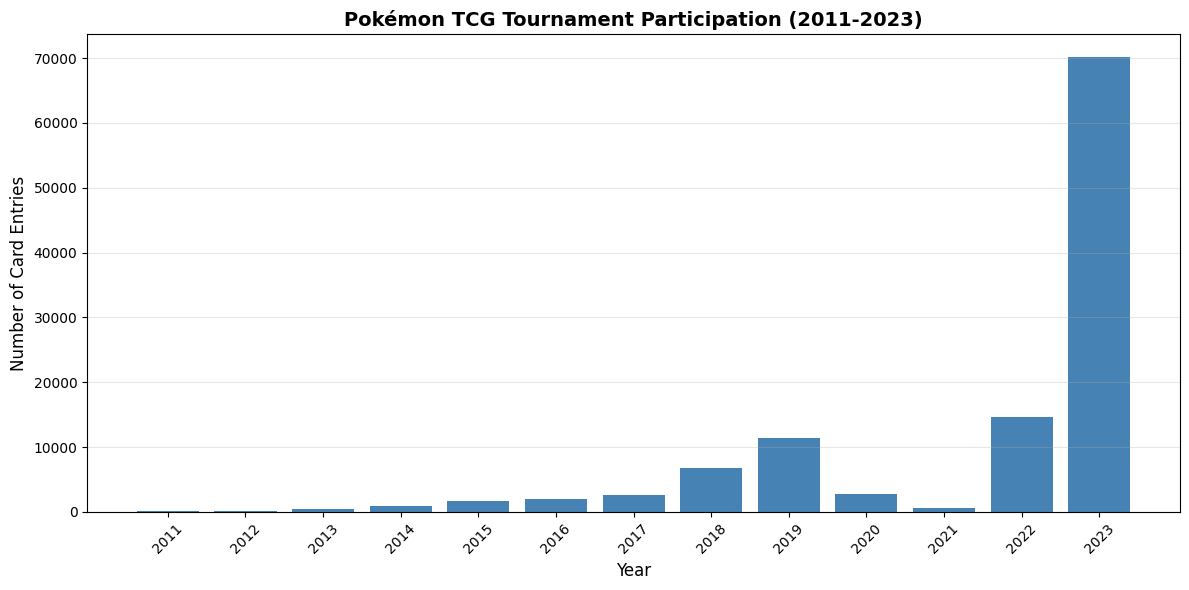

In [92]:
year_counts = df['year_tournament'].value_counts().sort_index()
plt.figure(figsize=(12,6))
plt.bar(year_counts.index, year_counts.values, color='steelblue')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Card Entries', fontsize=12)
plt.title('Pokémon TCG Tournament Participation (2011-2023)', fontsize=14, fontweight='bold')
plt.xticks(year_counts.index, rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

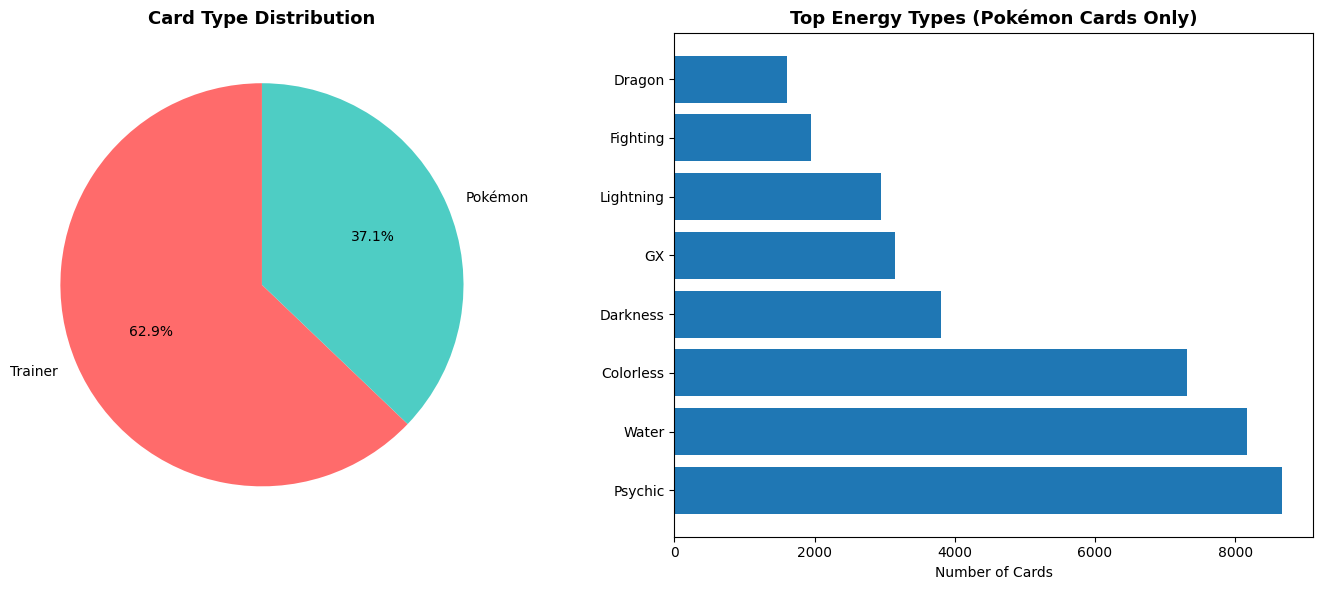

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Card type distribution
type_counts = df['type_card'].value_counts()
ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax1.set_title('Card Type Distribution', fontsize=13, fontweight='bold')

# Energy type distribution (Pokémon only)
energy_counts = df['energy_type_card'].dropna().value_counts().head(8)
ax2.barh(range(len(energy_counts)), energy_counts.values)
ax2.set_yticks(range(len(energy_counts)))
ax2.set_yticklabels(energy_counts.index)
ax2.set_xlabel('Number of Cards')
ax2.set_title('Top Energy Types (Pokémon Cards Only)', fontsize=13, fontweight='bold')
plt.tight_layout()

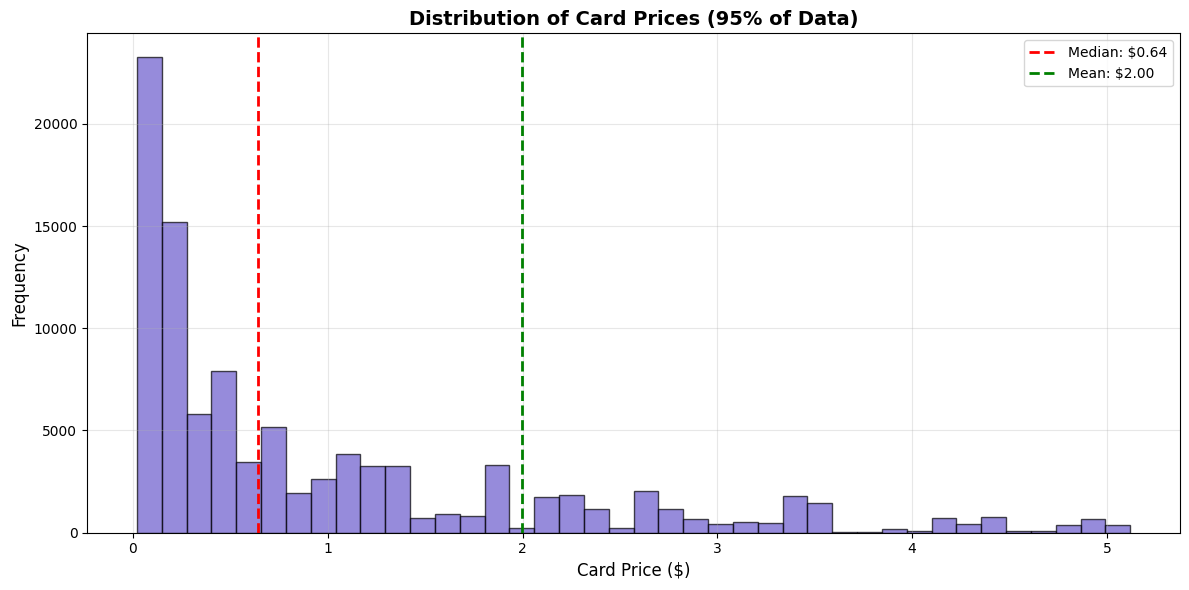

In [94]:
# Code for price analysis visualization
plt.figure(figsize=(12,6))
price_data = df['price_card'].dropna()

# Remove extreme outliers for better visualization
Q1 = price_data.quantile(0.25)
Q3 = price_data.quantile(0.75)
IQR = Q3 - Q1
filtered_prices = price_data[(price_data >= Q1 - 1.5*IQR) & (price_data <= Q3 + 1.5*IQR)]

plt.hist(filtered_prices, bins=40, edgecolor='black', alpha=0.7, color='#6A5ACD')
plt.axvline(price_data.median(), color='red', linestyle='--', linewidth=2, 
           label=f'Median: ${price_data.median():.2f}')
plt.axvline(price_data.mean(), color='green', linestyle='--', linewidth=2,
           label=f'Mean: ${price_data.mean():.2f}')
plt.xlabel('Card Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Card Prices (95% of Data)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

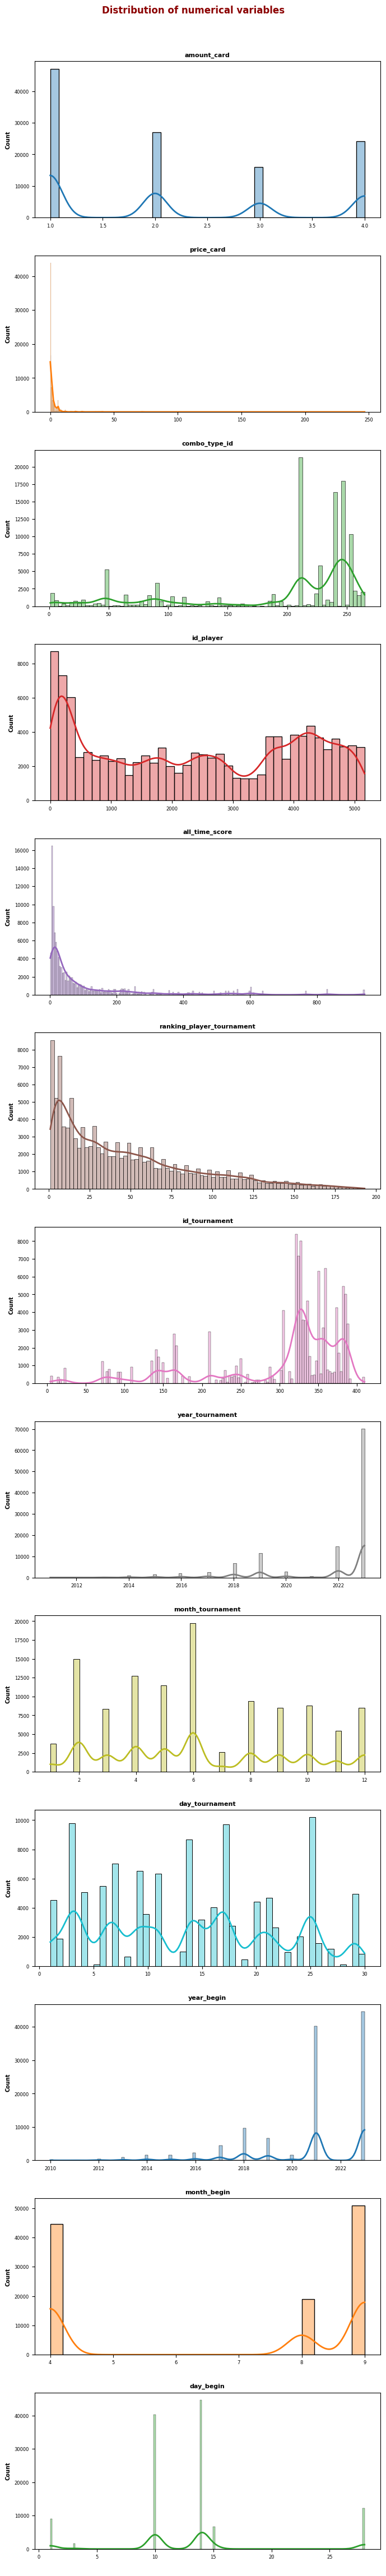

In [95]:
# Numerical variables:

fig,axes = plt.subplots(14, 1, figsize = (7, 50))
axes = axes.flat

for i, num_col in enumerate(num_cols):
  sns.histplot(df,
               x = num_col,
               stat = 'count',
               kde = True,
               color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
               line_kws = {'linewidth': 2},
               alpha = 0.4,
               ax = axes[i])

  axes[i].set_xlabel(" ")
  axes[i].set_ylabel("Count", fontsize = 7, fontweight = 'bold', color = 'black')
  axes[i].set_title(num_col, fontsize = 8, fontweight = 'bold', color = 'black')
  axes[i].tick_params(labelsize = 6)


fig.delaxes(axes[13])
fig.suptitle('Distribution of numerical variables', fontsize = 12, fontweight = 'bold', color = 'darkred')
fig.tight_layout()
fig.subplots_adjust(top = 0.96)
fig.show()

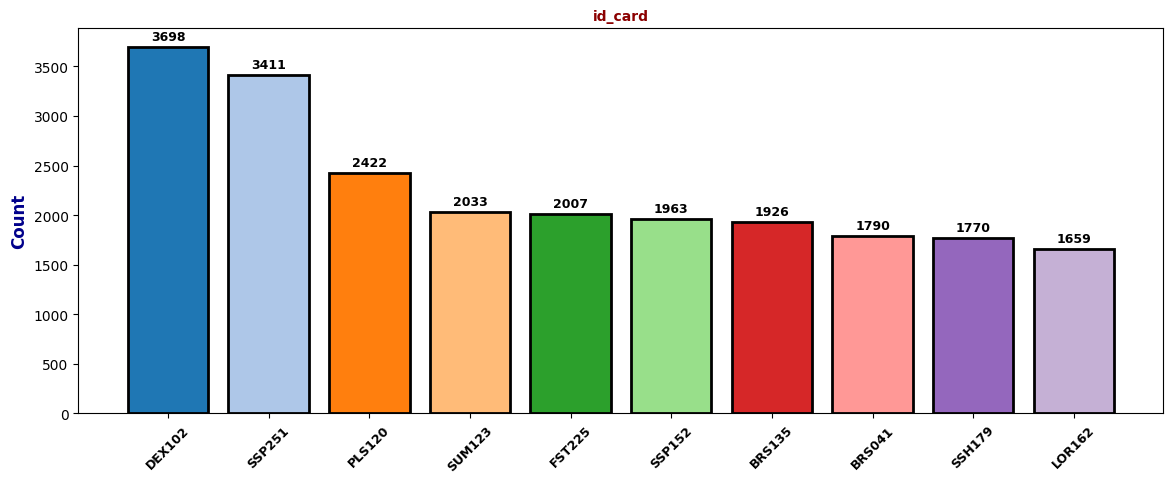

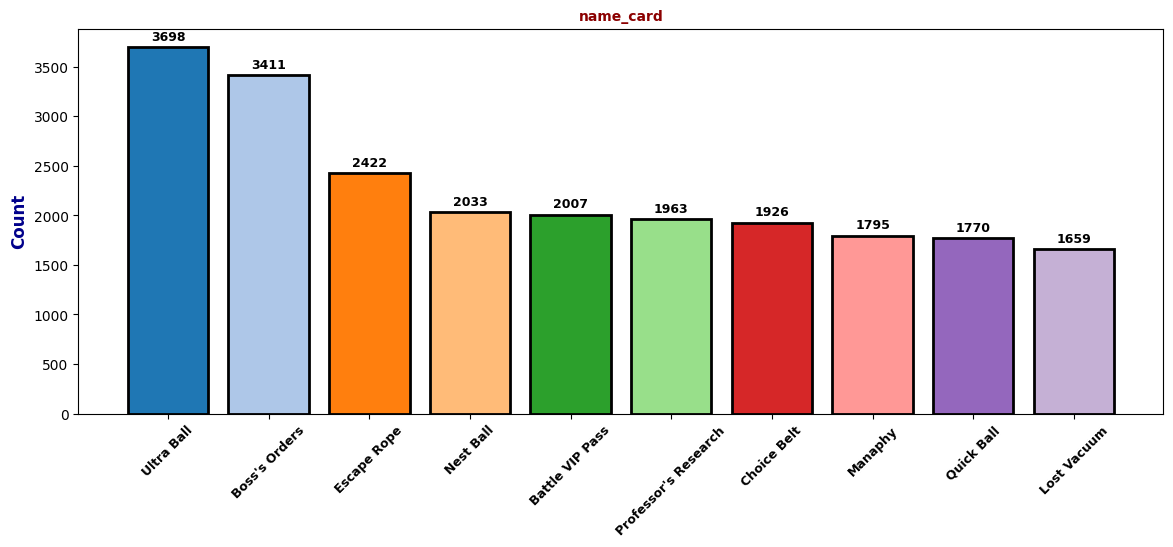

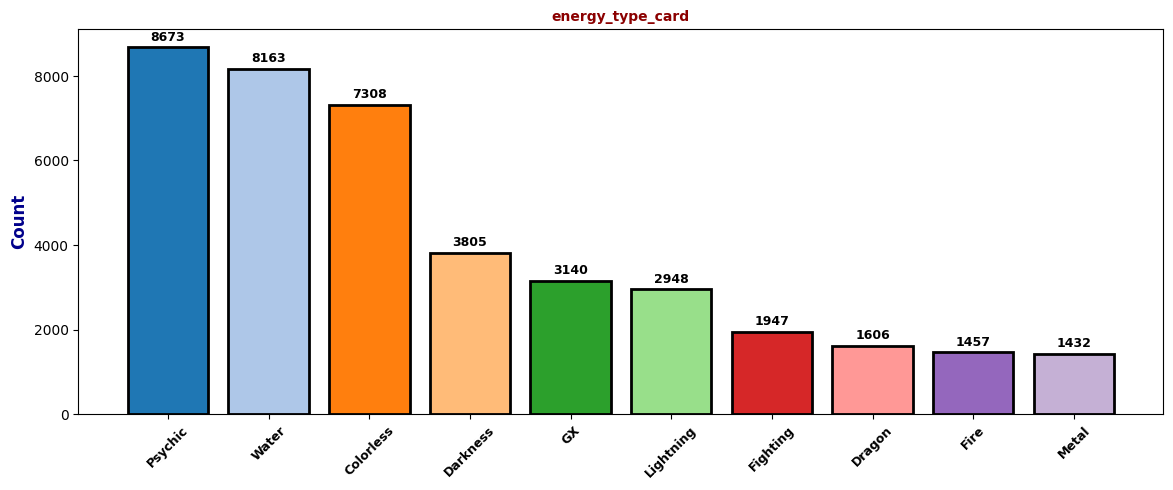

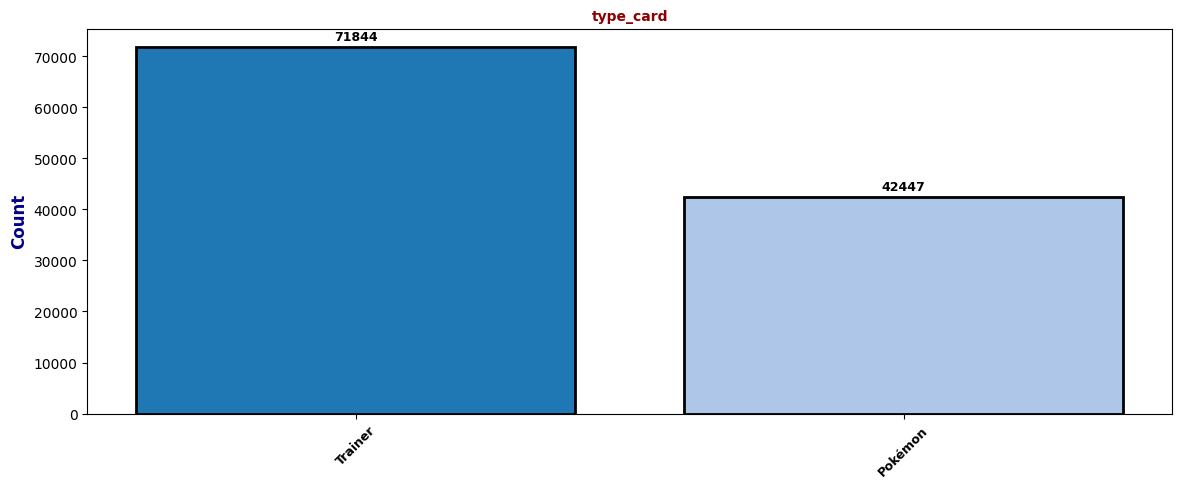

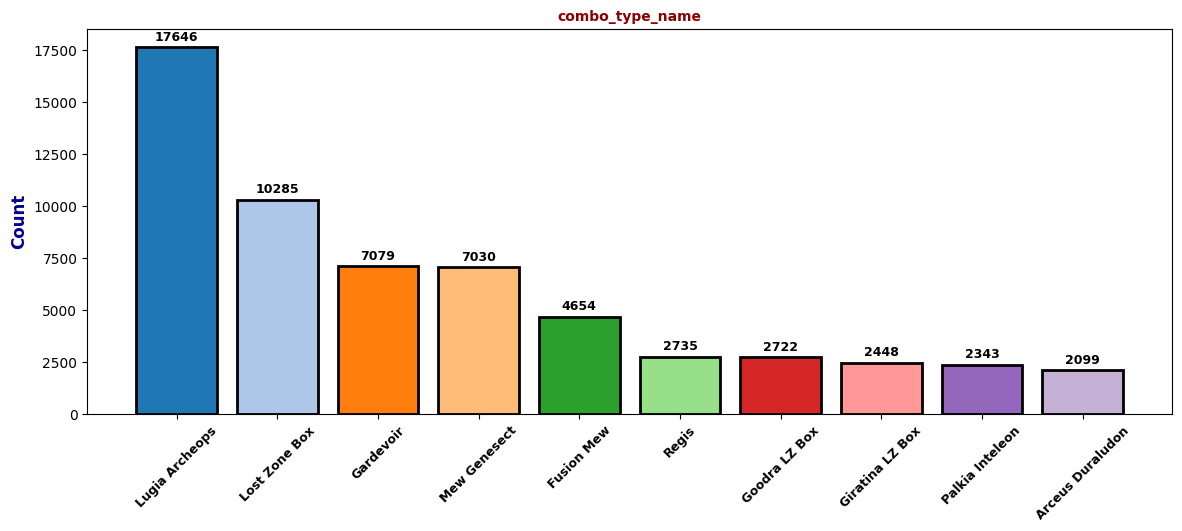

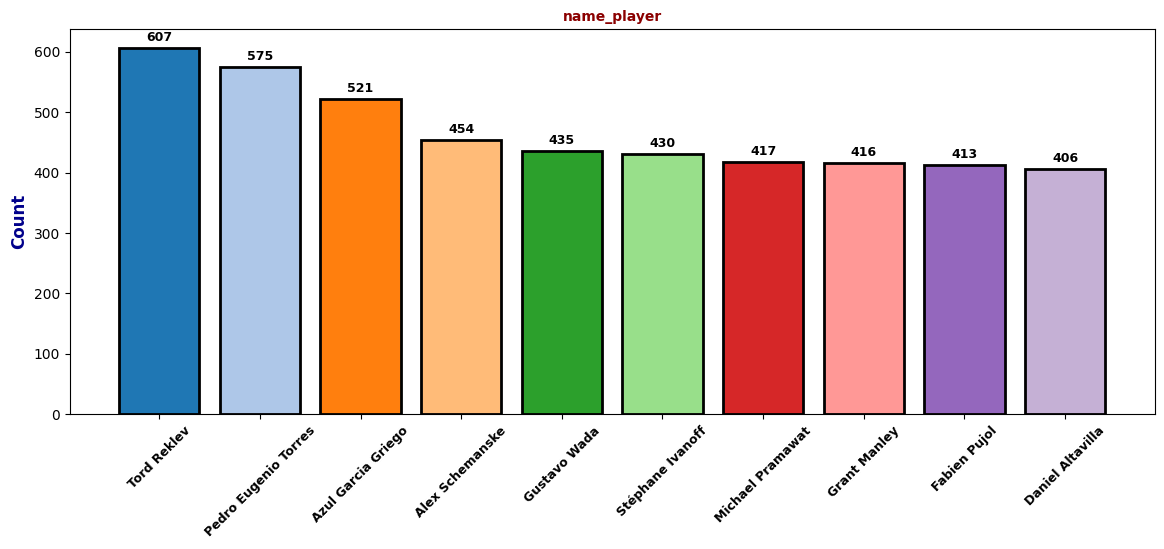

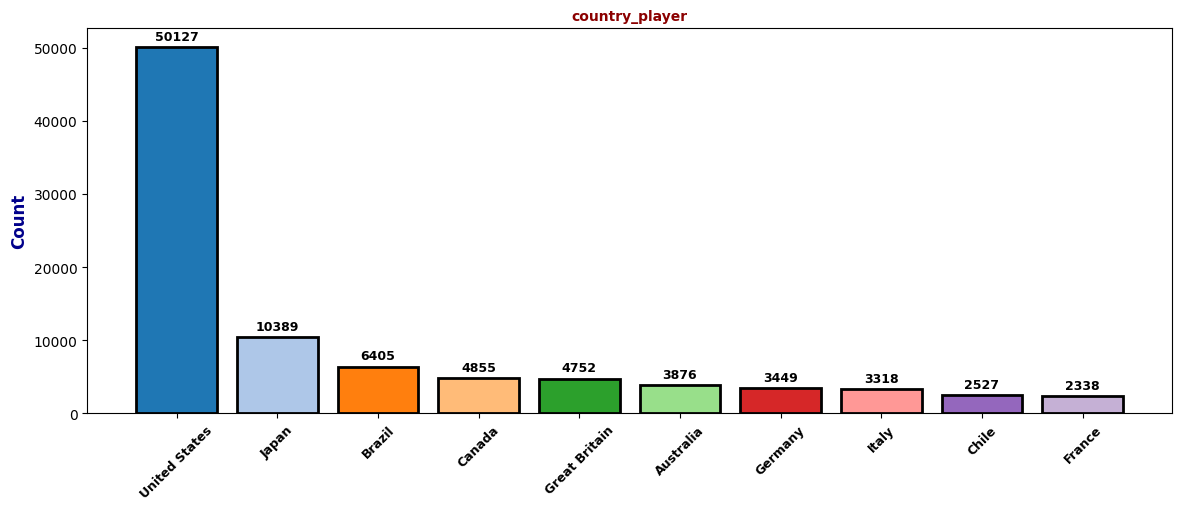

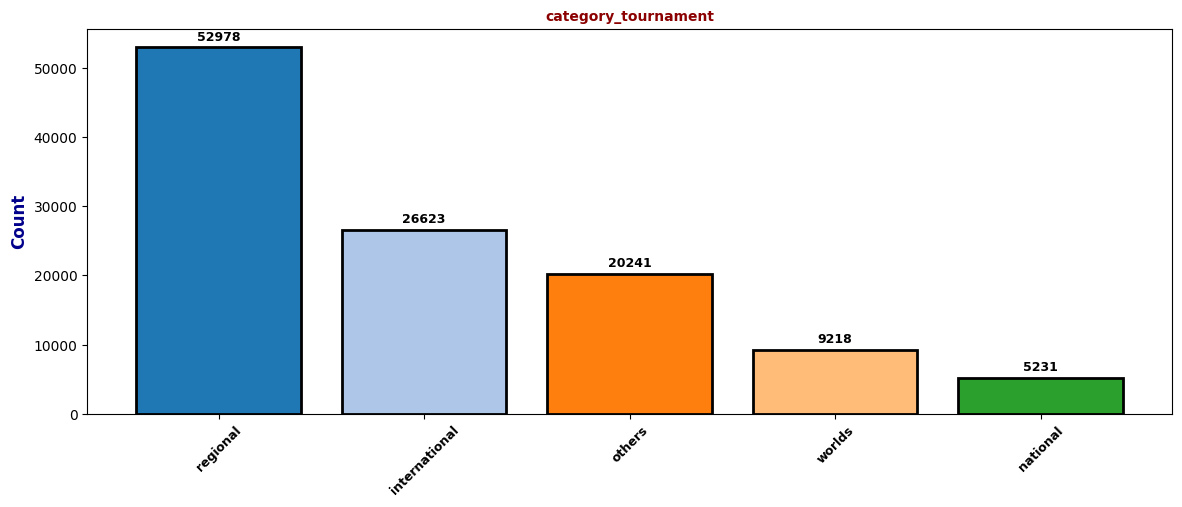

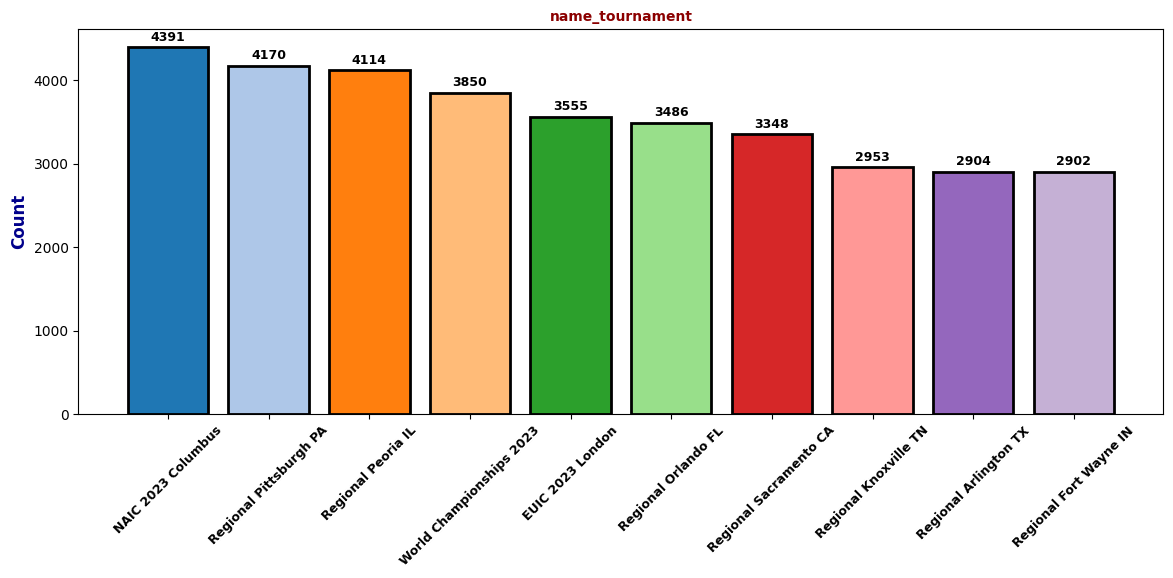

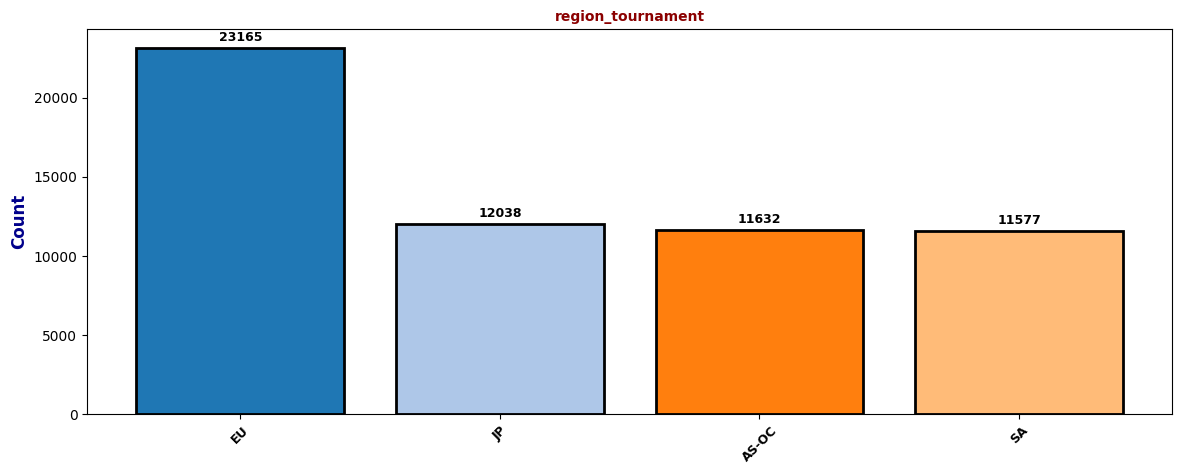

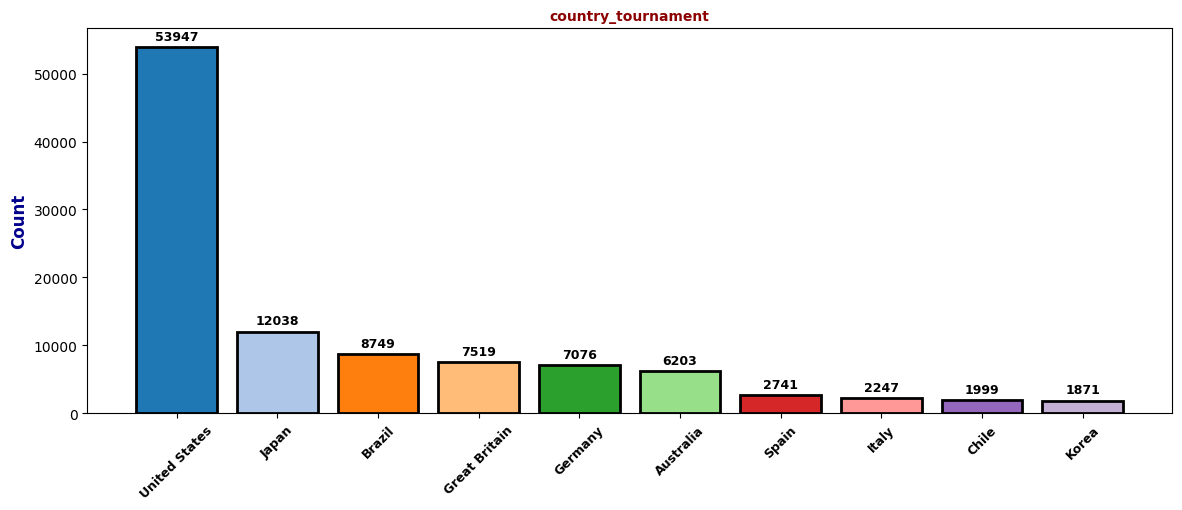

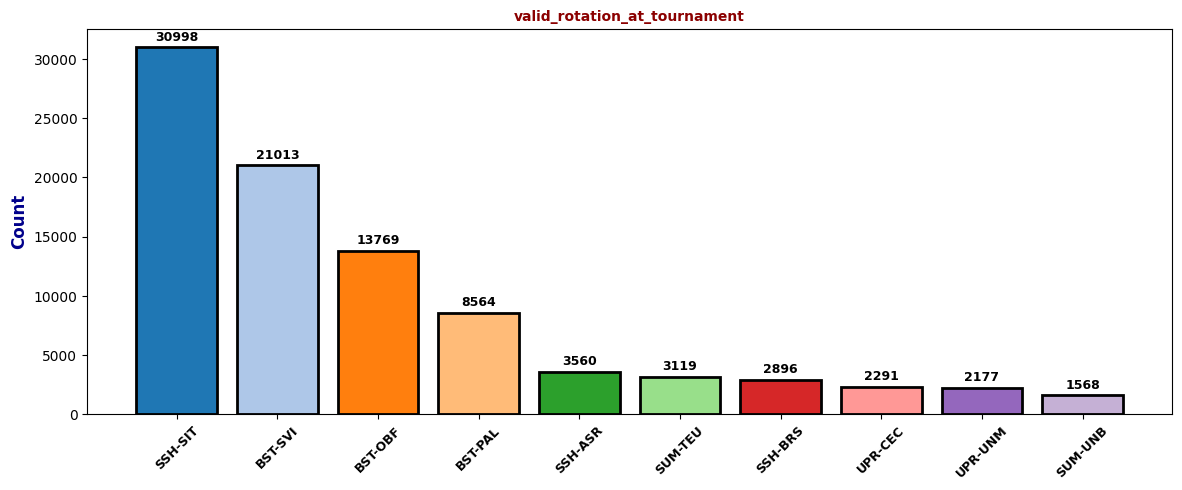

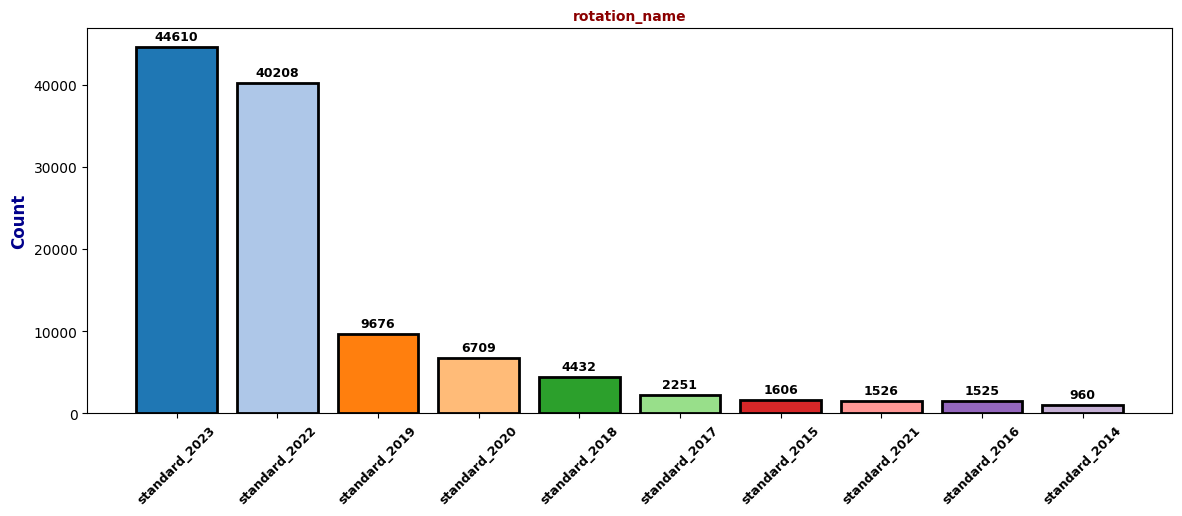

In [96]:
# Top 10 for Categorical variables

cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for i in cols:

        if i == 0:

            # We define the size of our figure.
            fig,ax = plt.subplots(figsize=(14,5))

            # 1. We create our dataframe that contains our data to be displayed.
            df_name = df[cat_cols[0]].value_counts().to_frame().head(10)

            # 2. We generate the values of our graphs.
            values = df_name.iloc[:,0]
            # 3. We generate the labels for our charts.
            labels = df_name.index.to_list()
            # 4. We generate the color map.
            cmap = plt.get_cmap('tab20')
            colors = cmap(np.arange(len(labels)))


            # 2. Bar chart.
            rects = ax.bar(labels, values, color = colors,
                              edgecolor = 'black', linewidth = 2.0)

            ax.set_title(f"{cat_cols[0]}", fontsize = 10, fontweight = 'bold', color = 'darkred')
            ax.set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
            ax.set_xticklabels(labels, fontsize = 9, fontweight = 'bold', rotation = 45)

            # function to label our bars.
            def autolabel(rects):
              for rect in rects:
                height = rect.get_height()
                ax.annotate(text = '{}'.format(height),
                            xy = (rect.get_x() + rect.get_width()/2., height-0.005),
                            xytext = (0,3),
                            textcoords = 'offset points',
                            va = 'bottom',
                            ha = 'center',
                            weight = 'bold',
                            size = 9,
                            color = 'black')

            autolabel(rects) # we label our bars.

            fig.show()
            
        else:
            
            # We define the size of our figure.
            fig,ax = plt.subplots(figsize=(14,5))

            # 1. We create our dataframe that contains our data to be displayed.
            df_name = df[cat_cols[i]].value_counts().to_frame().head(10)

            # 2. We generate the values of our graphs.
            values = df_name.iloc[:,0]
            # 3. We generate the labels for our charts.
            labels = df_name.index.to_list()
            # 4. We generate the color map.
            cmap = plt.get_cmap('tab20')
            colors = cmap(np.arange(len(labels)))


            # 2. Bar chart.
            rects = ax.bar(labels, values, color = colors,
                              edgecolor = 'black', linewidth = 2.0)

            ax.set_title(f"{cat_cols[i]}", fontsize = 10, fontweight = 'bold', color = 'darkred')
            ax.set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
            ax.set_xticklabels(labels, fontsize = 9, fontweight = 'bold', rotation = 45)

            # function to label our bars.
            def autolabel(rects):
              for rect in rects:
                height = rect.get_height()
                ax.annotate(text = '{}'.format(height),
                            xy = (rect.get_x() + rect.get_width()/2., height-0.005),
                            xytext = (0,3),
                            textcoords = 'offset points',
                            va = 'bottom',
                            ha = 'center',
                            weight = 'bold',
                            size = 9,
                            color = 'black')

            autolabel(rects) # we label our bars.

            fig.show()
            

            